# Mål

Estimere total strømningshastighet gjennom en strupeventil. 
Total flow, av olje, gas og vann, er `QTOT`

Dataset er markert følgende:
- `CHK`: strupeventil opening - et nummer mellom [0,1]. 0 er lukker, 1 er helt åpen. 
- `PWH`: Trykk upstream fra strupeventilen (skalert)
- `PDC`: trykk downstream fra strupeventilen (skalert)
- `TWH`: temperatur upstream fra strupeventilen (skalert)
- `FGAS`: brøkdel av gass til total strømning,  mellom [0,1]
- `FOIL`: brøkdel av vann til total strømning, mellom [0,1]

Figur:

<img src="well_sensors.png">

### Ingen modell for total strømningshastighet, løsning: Dyp Læring

Med et dyp læring nettverk, skal vi lage en prediksjon:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$


# Framework - Keras

Open-source bibliotek for dyp læring i Python.
Bygget På tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


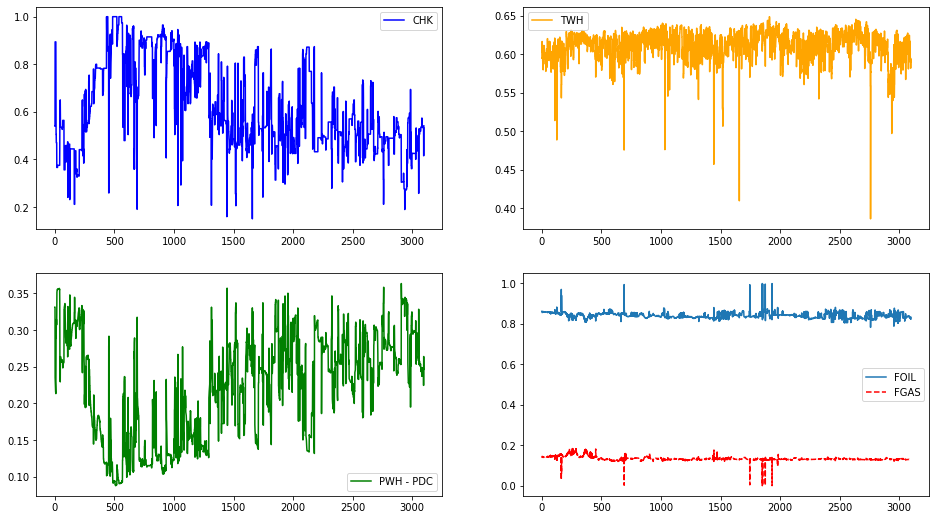

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

## Korrelasjon mellom data

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


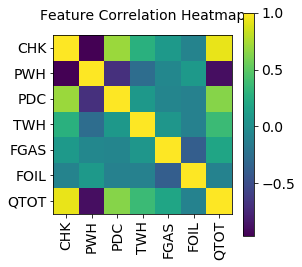

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Split til training, validation og data set.

### Test data

In [6]:
test_set = df[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

### Validation data

In [7]:
train_val_set = df.copy().drop(test_set.index) 
#train_val_set = df.iloc[0:500]

val_set = train_val_set.sample(frac=0.1, replace=False)

x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]

### Training data

In [8]:
train_set = train_val_set.copy().drop(val_set.index)

x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]

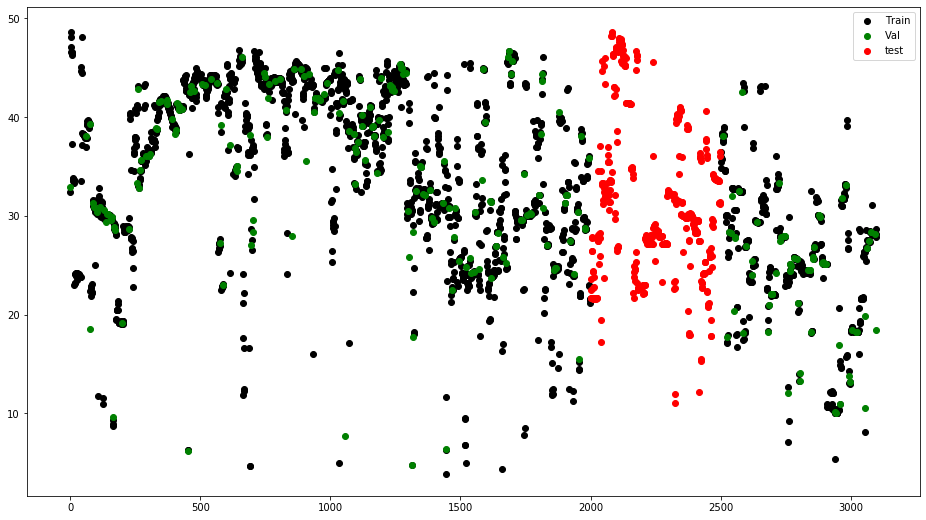

In [9]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Enkel model

- 2 hidden layers
- 6 + 128 + 64 + 1 noder

<img src="neural_network.jpg" width=600>

## Activation function
### Relu

<img src="relu.png" width=500>

Med Keras blir alle vektene initialisert til 0

In [10]:
from keras import regularizers

input_layer_size = x_train.columns.size

model = keras.Sequential()
model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,259
Trainable params: 9,259
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [13]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10,verbose=2)

Epoch 1/200
234/234 - 0s - loss: 395.3827 - val_loss: 76.3630
Epoch 2/200
234/234 - 0s - loss: 50.4111 - val_loss: 39.0499
Epoch 3/200
234/234 - 0s - loss: 19.6629 - val_loss: 15.4215
Epoch 4/200
234/234 - 0s - loss: 11.2905 - val_loss: 13.1539
Epoch 5/200
234/234 - 0s - loss: 10.4682 - val_loss: 12.3256
Epoch 6/200
234/234 - 0s - loss: 10.0806 - val_loss: 11.8326
Epoch 7/200
234/234 - 0s - loss: 9.8243 - val_loss: 11.2716
Epoch 8/200
234/234 - 0s - loss: 9.4716 - val_loss: 11.4154
Epoch 9/200
234/234 - 0s - loss: 9.1322 - val_loss: 10.9703
Epoch 10/200
234/234 - 0s - loss: 8.8406 - val_loss: 10.8030
Epoch 11/200
234/234 - 0s - loss: 8.2378 - val_loss: 9.9797
Epoch 12/200
234/234 - 0s - loss: 7.9903 - val_loss: 9.2557
Epoch 13/200
234/234 - 0s - loss: 7.6641 - val_loss: 8.9205
Epoch 14/200
234/234 - 0s - loss: 7.2918 - val_loss: 9.4386
Epoch 15/200
234/234 - 0s - loss: 6.9282 - val_loss: 8.6208
Epoch 16/200
234/234 - 0s - loss: 6.6828 - val_loss: 8.2763
Epoch 17/200
234/234 - 0s - loss

Epoch 137/200
234/234 - 0s - loss: 4.0540 - val_loss: 5.6042
Epoch 138/200
234/234 - 0s - loss: 4.0727 - val_loss: 5.7983
Epoch 139/200
234/234 - 0s - loss: 4.1420 - val_loss: 6.4418
Epoch 140/200
234/234 - 0s - loss: 4.0922 - val_loss: 5.6861
Epoch 141/200
234/234 - 0s - loss: 4.0089 - val_loss: 6.1200
Epoch 142/200
234/234 - 0s - loss: 3.9981 - val_loss: 5.8024
Epoch 143/200
234/234 - 0s - loss: 3.9182 - val_loss: 5.9577
Epoch 144/200
234/234 - 0s - loss: 4.0686 - val_loss: 6.5893
Epoch 145/200
234/234 - 0s - loss: 4.0194 - val_loss: 6.8452
Epoch 146/200
234/234 - 0s - loss: 4.0719 - val_loss: 5.9813
Epoch 147/200
234/234 - 0s - loss: 4.1291 - val_loss: 5.7599
Epoch 148/200
234/234 - 0s - loss: 3.9473 - val_loss: 5.6793
Epoch 149/200
234/234 - 0s - loss: 3.8064 - val_loss: 5.8274
Epoch 150/200
234/234 - 0s - loss: 4.0271 - val_loss: 5.7183
Epoch 151/200
234/234 - 0s - loss: 3.9821 - val_loss: 5.6380
Epoch 152/200
234/234 - 0s - loss: 3.9434 - val_loss: 6.5188
Epoch 153/200
234/234 - 

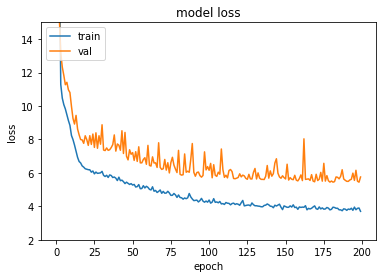

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([2,15])
plt.show()

In [15]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [16]:

print("Error on test data simple model")
mse_test_simple = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_simple) #2.6873526

mae_test_simple = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test_simple) # 1.12

mape_test_simple = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_simple, "%") # 3.574



Error on test data simple model
MSE:  3.683543097961413
MAE:  1.415387543544379
MAPE:  4.1377130148534755 %


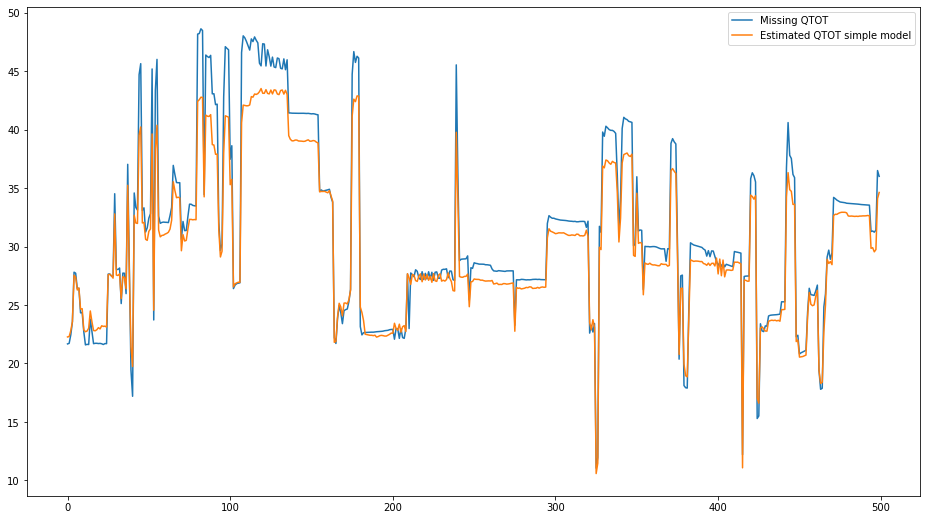

In [17]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.legend()

# Ny model

### Legge til dropout lag

In [27]:
from keras.layers import Dropout

input_layer_size = x_train.columns.size

improved_model = keras.Sequential()
improved_model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
improved_model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(1))

In [28]:
improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [29]:
improved_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Early stopping

In [30]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

callback = EarlyStopping(monitor='val_loss', patience=6)


improved_history = improved_model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
234/234 - 0s - loss: 1091.7529 - val_loss: 873.3978
Epoch 2/200
234/234 - 0s - loss: 643.2737 - val_loss: 253.8682
Epoch 3/200
234/234 - 0s - loss: 126.0502 - val_loss: 71.1945
Epoch 4/200
234/234 - 0s - loss: 67.9771 - val_loss: 69.4645
Epoch 5/200
234/234 - 0s - loss: 65.2295 - val_loss: 67.0018
Epoch 6/200
234/234 - 0s - loss: 62.4711 - val_loss: 64.5759
Epoch 7/200
234/234 - 0s - loss: 59.3670 - val_loss: 61.0517
Epoch 8/200
234/234 - 0s - loss: 56.2593 - val_loss: 58.5833
Epoch 9/200
234/234 - 0s - loss: 52.9093 - val_loss: 56.2666
Epoch 10/200
234/234 - 0s - loss: 49.4483 - val_loss: 51.7617
Epoch 11/200
234/234 - 0s - loss: 45.8026 - val_loss: 48.7170
Epoch 12/200
234/234 - 0s - loss: 42.0779 - val_loss: 45.3439
Epoch 13/200
234/234 - 0s - loss: 38.2583 - val_loss: 40.5197
Epoch 14/200
234/234 - 0s - loss: 34.2766 - val_loss: 36.5827
Epoch 15/200
234/234 - 0s - loss: 30.2484 - val_loss: 32.6106
Epoch 16/200
234/234 - 0s - loss: 26.1956 - val_loss: 28.7824
Epoch 17/20

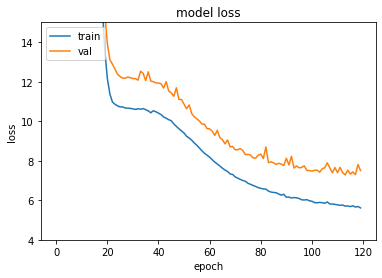

In [36]:
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([4,15])
plt.show()

In [32]:
improved_keras_predictions = improved_model.predict(x_test, verbose=2)

16/16 - 0s


In [33]:

print("Error on test data improved model")
mse_test_improved = np.mean(np.power(improved_keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_improved) #2.6873526

mae_test_improved = np.mean(np.abs(improved_keras_predictions-y_test.values))
print("MAE: ", mae_test_improved) # 1.12

mape_test_improved = 100*np.mean(np.abs(np.divide(improved_keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_improved, "%") # 3.574



Error on test data improved model
MSE:  2.79631617942787
MAE:  1.0984886401558205
MAPE:  3.288632197196949 %


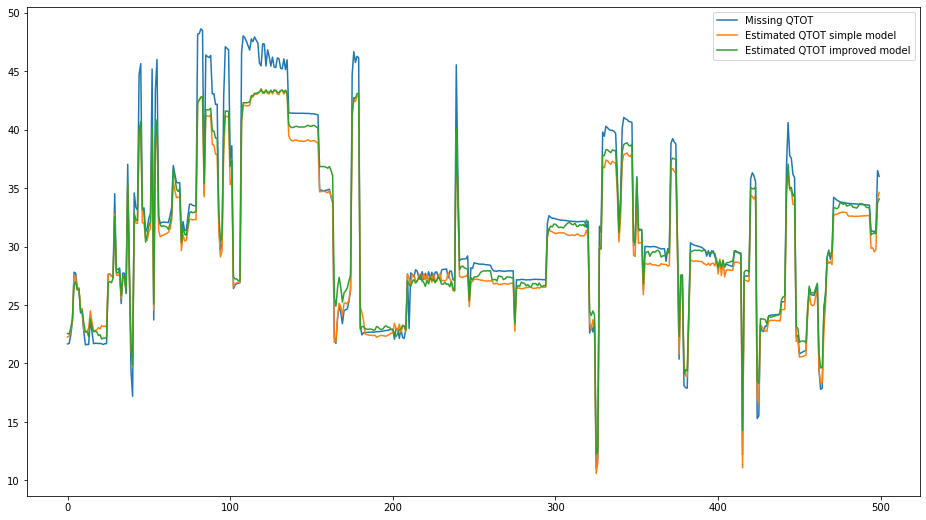

In [34]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.plot(improved_keras_predictions, label='Estimated QTOT improved model')
plt.legend()

In [35]:
import numpy as np
from tabulate import tabulate

m = np.array([["MSE", mse_test_simple, mse_test_improved],["MAE", mae_test_simple, mae_test_improved ],["MAPE", mape_test_simple, mape_test_improved]]);

headers = ["old", "new"]

table = tabulate(m, headers, tablefmt="fancy_grid")

print(table)


╒══════╤═════════╤═════════╕
│      │     old │     new │
╞══════╪═════════╪═════════╡
│ MSE  │ 3.68354 │ 2.79632 │
├──────┼─────────┼─────────┤
│ MAE  │ 1.41539 │ 1.09849 │
├──────┼─────────┼─────────┤
│ MAPE │ 4.13771 │ 3.28863 │
╘══════╧═════════╧═════════╛
